In [1]:
%pylab inline

from PyTools import err, binner
from itertools import product
import os
import pyfits as pyf
from scipy.ndimage.filters import gaussian_filter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

Populating the interactive namespace from numpy and matplotlib


In [2]:
rc("lines", linewidth=1.0)
rc("patch", linewidth=1.0)
rc("font", family="sans-serif", serif="Helvetica", size=20)
rc("savefig", dpi=92)
rc("legend", fontsize="x-small")
rc("xtick", labelsize="x-small")
rc("ytick", labelsize="x-small")

def same_names(table, replace, replacement, keyword="input_file"):
    table[keyword] = [n.replace(replace, replacement).replace("txt", "fit") for n in table[keyword]]

def put_FITS_names(table):
    descr = table.dtype.descr
    for i in xrange(3): descr.pop(0)
    descr = [("input_file", "|S25")] + descr

    new_table = zeros(table.shape[0], dtype=descr)
    new_table["input_file"] = ["spSpec-{0:05d}-{1:04d}-{2:03d}.fit".format(r["mjd"], r["plate"], r["fiberID"]) for r in table]
    for f in new_table.dtype.names[1:]:
        new_table[f] = table[f]
    
    return new_table

In [3]:
#READ TABLES

odir = "../outputs/real_deal6/"

catalog = genfromtxt(odir+"ugriz_catalog_rf.txt", dtype=None, names=True)
spec_ne = genfromtxt(odir+"wmx_dynbas_table_4Zspec.txt", dtype=None, names=True)
jpas_ye = genfromtxt(odir+"wmx_dynbas_table_4Zjpas.txt", dtype=None, names=True)
jpas_ne = genfromtxt(odir+"wmx_dynbas_table_4Zjpas_nem.txt", dtype=None, names=True)

gal2005 = genfromtxt("../../gallazzi+05/gallazzi_stats.log", dtype=None, names=True)

print "tables read..."
#CLEAN CATALOG

toremove, = where(isinf(catalog["u_mag"]))
catalog = delete(catalog, toremove, axis=0)

print "catalog cleaned..."
#CLEAN GAL2005

toremove, = where(gal2005["m_mode"]<0)
gal2005 = delete(gal2005, toremove, axis=0)

print "gal2005 cleaned..."
#FILTER UNIQUE

catalog = catalog[unique(catalog["input_file"], True)[1]]
spec_ne = spec_ne[unique(spec_ne["input_file"], True)[1]]
jpas_ye = jpas_ye[unique(jpas_ye["input_file"], True)[1]]
jpas_ne = jpas_ne[unique(jpas_ne["input_file"], True)[1]]

print "removed repeated records..."
#SAME NAMES

same_names(spec_ne, replace="processed_SPEC_", replacement="")
same_names(jpas_ye, replace="processed_JPAS_", replacement="")
same_names(jpas_ne, replace="processed_nem_JPAS_", replacement="")

gal2005 = put_FITS_names(gal2005)

print "homologated input_file fields..."
#MERGE JPAS_NE

missing = [i for i in xrange(jpas_ye.size) if jpas_ye["input_file"][i] not in jpas_ne["input_file"]]

jpas_me = zeros(jpas_ne.size+len(missing), dtype=jpas_ne.dtype)
jpas_me[:jpas_ne.size] = jpas_ne
jpas_me[jpas_ne.size:] = jpas_ye[missing]

print "merged jpas_ne and jpas_ye tables into jpas_me..."
#MATCH TABLES

in_spec_ne, in_jpas_ye, in_jpas_me, in_gal2005 = [], [], [], []
id_spec_ne, id_jpas_ye, id_jpas_me, id_gal2005 = [], [], [], []
for i in xrange(catalog.size):
    in_spec_ne.append(catalog["input_file"][i] in spec_ne["input_file"])
    in_jpas_ye.append(catalog["input_file"][i] in jpas_ye["input_file"])
    in_jpas_me.append(catalog["input_file"][i] in jpas_me["input_file"])
    in_gal2005.append(catalog["input_file"][i] in gal2005["input_file"])
    if not in_spec_ne[-1] or not in_jpas_ye[-1] or not in_jpas_me[-1]: continue
    
    id_spec_ne.append(where(catalog["input_file"][i]==spec_ne["input_file"])[0][0])
    id_jpas_ye.append(where(catalog["input_file"][i]==jpas_ye["input_file"])[0][0])
    id_jpas_me.append(where(catalog["input_file"][i]==jpas_me["input_file"])[0][0])
    if in_gal2005[-1]: id_gal2005.append(where(catalog["input_file"][i]==gal2005["input_file"])[0][0])

print "matches found..."
print "checking out..."
print "   missing files spec_ne?", not all(in_spec_ne)
print "   missing files jpas_ye?", not all(in_jpas_ye)
print "   missing files jpas_me?", not all(in_jpas_me)
toremove = where(~array(in_spec_ne, bool))[0]
toremove = append(toremove, where(~array(in_jpas_ye, bool))[0])
toremove = append(toremove, where(~array(in_jpas_me, bool))[0])

spec_ne = spec_ne[id_spec_ne]
jpas_ye = jpas_ye[id_jpas_ye]
jpas_me = jpas_me[id_jpas_me]

gal2005 = gal2005[id_gal2005]

catalog = catalog[argsort(catalog["input_file"])]
spec_ne = spec_ne[argsort(spec_ne["input_file"])]
jpas_ye = jpas_ye[argsort(jpas_ye["input_file"])]
jpas_me = jpas_me[argsort(jpas_me["input_file"])]
jpas_ne = jpas_ne[argsort(jpas_ne["input_file"])]
gal2005 = gal2005[argsort(gal2005["input_file"])]

print "   all tables have the same?", all(all(catalog["input_file"]==spec_ne["input_file"])==all(spec_ne["input_file"]==jpas_ye["input_file"])==all(jpas_ye["input_file"]==jpas_me["input_file"]))
print "printing results..."
print
print "       ", "catalog", "spec_ne", "jpas_ye", "jpas_me", "jpas_ne", "gal2005"
print "No rows {0:7d} {1:7d} {2:7d} {3:7d} {4:7d} {5:7d}".format(catalog.size, spec_ne.size, jpas_ye.size, jpas_me.size, jpas_ne.size, gal2005.size)
#CONVERT UNITS

spec_ne["M_mod"] = log10(spec_ne["M_mod"])
jpas_ye["M_mod"] = log10(jpas_ye["M_mod"])
jpas_me["M_mod"] = log10(jpas_me["M_mod"])
jpas_ne["M_mod"] = log10(jpas_ne["M_mod"])
gal2005["z_mode"] = gal2005["z_mode"] - log10(0.02)

tables read...
catalog cleaned...
gal2005 cleaned...
removed repeated records...
homologated input_file fields...
merged jpas_ne and jpas_ye tables into jpas_me...
matches found...
checking out...
   missing files spec_ne? False
   missing files jpas_ye? False
   missing files jpas_me? False
   all tables have the same? True
printing results...

        catalog spec_ne jpas_ye jpas_me jpas_ne gal2005
No rows   32188   32188   32188   32188   20874   19552


In [4]:
#COMMON QUANTITIES

lcolor = catalog["u_mag"] - catalog["r_mag"]

bmask = lcolor < 2.22
rmask = ~bmask
nmask = array([n in jpas_ne["input_file"] for n in jpas_me["input_file"]], dtype=bool)
gmask = array([n in gal2005["input_file"] for n in catalog["input_file"]], dtype=bool)

kw = "M_mod log_t_M_mod log_t_L_mod log_Z_M_mod log_Z_L_mod Av_mod".split()
rl = [False]*6
lb = [r"$\Delta \log{M_\star/M\odot}$", r"$\Delta\left<\log{t_\star}\right>_M$",
      r"$\Delta\left<\log{t_\star}\right>_L$", r"$\Delta\left<\log{Z_\star/Z\odot}\right>_M$",
      r"$\Delta\left<\log{Z_\star/Z\odot}\right>_L$", r"$\Delta A_V$"]

In [5]:
#CLEAN UP

del toremove, missing, jpas_ne
del in_spec_ne, in_jpas_ye, in_jpas_me
del id_spec_ne, id_jpas_ye, id_jpas_me

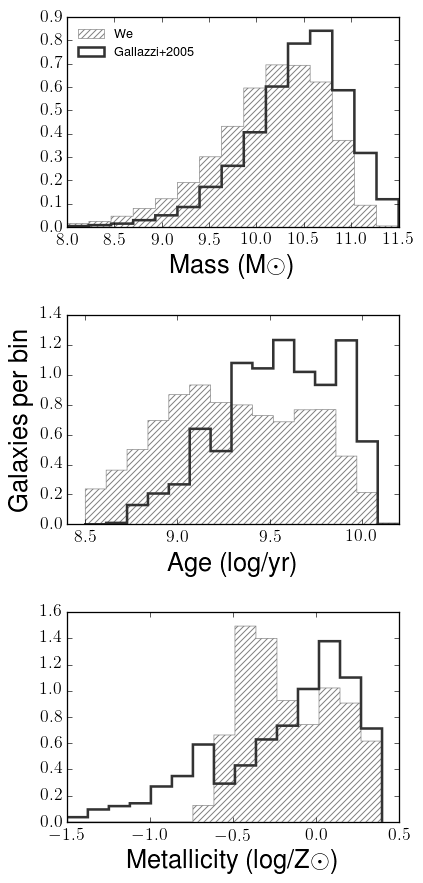

In [6]:
fig, axs = subplots(3, 1, figsize=(5, 10))

axs[0].hist(spec_ne["M_mod"][gmask], 15, (8, 11.5), True, histtype="step", lw=0.5, hatch="////", color="0.5", label="We")
axs[0].hist(gal2005["m_mode"], 15, (8, 11.5), True, histtype="step", lw=2, color="0.2", label="Gallazzi+2005")
axs[0].legend(loc=2, fontsize=10)
axs[0].set_xlabel("Mass (M$\odot$)")

axs[1].hist(spec_ne["log_t_L_mod"][gmask], 15, (8.5, 10.2), True, histtype="step", lw=0.5, hatch="////", color="0.5")
axs[1].hist(gal2005["t_mode"], 15, (8.5, 10.2), True, histtype="step", lw=2, color="0.2")
axs[1].set_xlabel("Age (log/yr)")
axs[1].set_ylabel("Galaxies per bin")

axs[2].hist(spec_ne["log_Z_L_mod"][gmask], 15, (-1.5, 0.4), True, histtype="step", lw=0.5, hatch="////", color="0.5")
axs[2].hist(gal2005["z_mode"], 15, (-1.5, 0.4), True, histtype="step", lw=2, color="0.2")
axs[2].set_xlabel("Metallicity (log/Z$\odot$)")

fig.tight_layout()
savefig("we_vs_gal2005", bbox_inches="tight")

tables match?  True
0.0228
0.0361


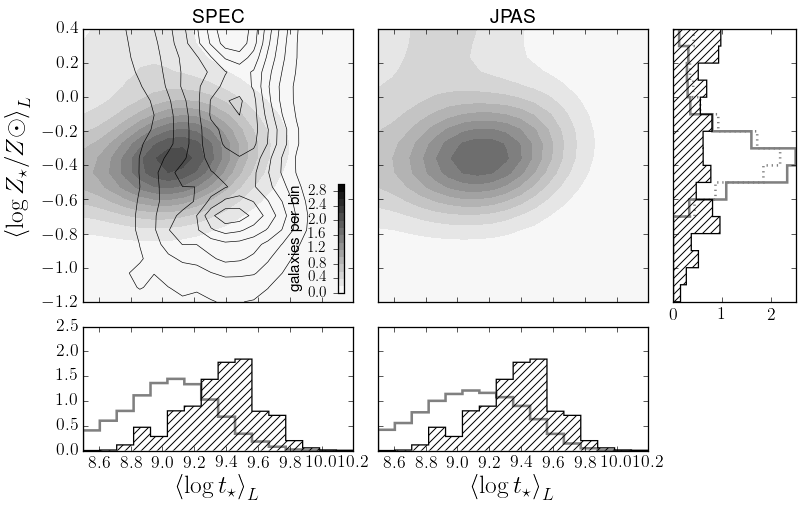

In [7]:
mask = gmask&bmask
mgal = lcolor[gmask]<2.22

print "tables match? ", all(spec_ne["input_file"][mask]==gal2005["input_file"][mgal])

i, j = 2, 4
ts = spec_ne
tj = jpas_me
tg = gal2005
lv = arange(0, 3.2, 0.2)
lt = 8.5, 10.2
lz = -1.2, 0.4

figure(figsize=(10, 8))
axs = subplot2grid((4, 5), (0, 0), rowspan=2, colspan=2, xlim=lt, ylim=lz, xticklabels=[])
axj = subplot2grid((4, 5), (0, 2), rowspan=2, colspan=2, xlim=lt, ylim=lz, xticklabels=[], yticklabels=[])
xts = subplot2grid((4, 5), (2, 0), colspan=2, xlim=lt, ylim=(0, 2.5))
xtj = subplot2grid((4, 5), (2, 2), colspan=2, xlim=lt, ylim=(0, 2.5), yticklabels=[])
axz = subplot2grid((4, 5), (0, 4), rowspan=2, ylim=lz, yticklabels=[])
ins = inset_axes(axs, width="2.5%", height="40%", loc=4)

ns, xes, yes = histogram2d(ts[kw[i]][mask], ts[kw[j]][mask], 20, [lt, lz], normed=True)
ns = gaussian_filter(ns, sigma=2)
nj, xej, yej = histogram2d(tj[kw[i]][mask], tj[kw[j]][mask], 20, [lt, lz], normed=True)
nj = gaussian_filter(nj, sigma=2)
ng, xeg, yeg = histogram2d(tg["t_mode"][mgal], tg["z_mode"][mgal], 20, [lt, lz], normed=True)
ng = gaussian_filter(ng, sigma=1)

cn = axs.contourf(ns.T, 10, levels=lv, cmap=cm.gray_r, extent=lt+lz)
cb = colorbar(cn, cax=ins)
cb.set_label("galaxies per bin", size=12)
cn = axj.contourf(nj.T, 10, levels=lv, cmap=cm.gray_r, extent=lt+lz)
cn = axs.contour(ng.T, 10, levels=lv, colors="k", linewidths=0.5, extent=lt+lz)

xts.hist(ts[kw[i]][mask], lv.size, lt, True, histtype="step", color="0.5", lw=2)
xts.hist(tg["t_mode"][mgal], lv.size, lt, True, histtype="step", hatch="///", color="k")
xtj.hist(tj[kw[i]][mask], lv.size, lt, True, histtype="step", color="0.5", lw=2)
xtj.hist(tg["t_mode"][mgal], lv.size, lt, True, histtype="step", hatch="///", color="k")
n, y, p = axz.hist([ts[kw[j]][mask], tj[kw[j]][mask]], lv.size, lz, True, histtype="step", lw=2, orientation="horizontal")

for ps, pj in zip(*p):
    ps.set_linestyle("solid")
    ps.set_edgecolor("0.5")
    pj.set_linestyle("dotted")
    pj.set_edgecolor("0.5")

axz.hist(tg["z_mode"][mgal], lv.size, lz, True, histtype="step", hatch="///", color="k", orientation="horizontal")

ins.tick_params(labelsize=12, direction="out", left=True, right=False, labelleft="on", labelright="off")
ins.yaxis.set_label_position("left")

axz.set_xticks(axz.get_xticks()[::2])
axs.set_title("SPEC", {"fontsize":15})
axj.set_title("JPAS", {"fontsize":15})
xts.set_xlabel(lb[i].replace("\Delta", ""))
xtj.set_xlabel(lb[i].replace("\Delta", ""))
axs.set_ylabel(lb[j].replace("\Delta", ""))

print median(tj[kw[i]][mask])-median(ts[kw[i]][mask])
print median(tj[kw[j]][mask])-median(ts[kw[j]][mask])

savefig("gal2005_plot", bbox_inches="tight")

-0.0576
0.0698


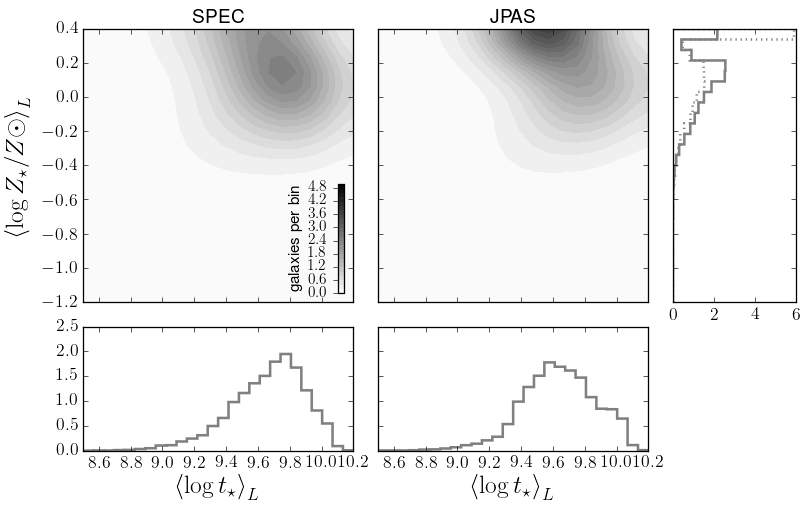

In [8]:
mask = rmask&(spec_ne["M_mod"]>10)

i, j = 2, 4
ts = spec_ne
tj = jpas_me
lv = arange(0, 5.2, 0.2)
lt = 8.5, 10.2
lz = -1.2, 0.4

figure(figsize=(10, 8))
axs = subplot2grid((4, 5), (0, 0), rowspan=2, colspan=2, xlim=lt, ylim=lz, xticklabels=[])
axj = subplot2grid((4, 5), (0, 2), rowspan=2, colspan=2, xlim=lt, ylim=lz, xticklabels=[], yticklabels=[])
xts = subplot2grid((4, 5), (2, 0), colspan=2, xlim=lt, ylim=(0, 2.5))
xtj = subplot2grid((4, 5), (2, 2), colspan=2, xlim=lt, ylim=(0, 2.5), yticklabels=[])
axz = subplot2grid((4, 5), (0, 4), rowspan=2, ylim=lz, yticklabels=[])
ins = inset_axes(axs, width="2.5%", height="40%", loc=4)

ns, xes, yes = histogram2d(ts[kw[i]][mask], ts[kw[j]][mask], 20, [lt, lz], normed=True)
ns = gaussian_filter(ns, sigma=2)
nj, xej, yej = histogram2d(tj[kw[i]][mask], tj[kw[j]][mask], 20, [lt, lz], normed=True)
nj = gaussian_filter(nj, sigma=2)

cn = axs.contourf(ns.T, 10, levels=lv, cmap=cm.gray_r, extent=lt+lz)
cb = colorbar(cn, cax=ins)
cb.set_label("galaxies per bin", size=12)
cn = axj.contourf(nj.T, 10, levels=lv, cmap=cm.gray_r, extent=lt+lz)

xts.hist(ts[kw[i]][mask], lv.size, lt, True, histtype="step", color="0.5", lw=2)
xtj.hist(tj[kw[i]][mask], lv.size, lt, True, histtype="step", color="0.5", lw=2)
n, y, p = axz.hist([ts[kw[j]][mask], tj[kw[j]][mask]], lv.size, lz, True, histtype="step", lw=2, orientation="horizontal")

for ps, pj in zip(*p):
    ps.set_linestyle("solid")
    ps.set_edgecolor("0.5")
    pj.set_linestyle("dotted")
    pj.set_edgecolor("0.5")

ins.tick_params(labelsize=12, direction="out", left=True, right=False, labelleft="on", labelright="off")
ins.yaxis.set_label_position("left")

axz.set_xticks(axz.get_xticks()[::2])
axs.set_title("SPEC", {"fontsize":15})
axj.set_title("JPAS", {"fontsize":15})
xts.set_xlabel(lb[i].replace("\Delta", ""))
xtj.set_xlabel(lb[i].replace("\Delta", ""))
axs.set_ylabel(lb[j].replace("\Delta", ""))

print median(tj[kw[i]][mask])-median(ts[kw[i]][mask])
print median(tj[kw[j]][mask])-median(ts[kw[j]][mask])

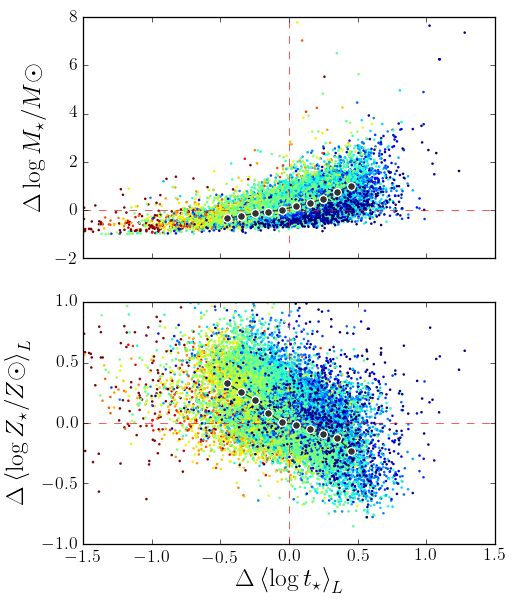

In [9]:
dm = err(10**ts["M_mod"], 10**tj["M_mod"], relative=True)
dt = err(ts["log_t_L_mod"], tj["log_t_L_mod"], relative=False)
dz = err(ts["log_Z_L_mod"], tj["log_Z_L_mod"], relative=False)
de = err(ts["Av_mod"], tj["Av_mod"], relative=False)

fig, axs = subplots(2, 1, figsize=(6, 7), sharex=True)
axs[0].scatter(dt, dm, c=de, s=4, lw=0, vmin=-.5, vmax=+.5)
axs[0].axhline(ls="--", color="r", lw=0.5)
axs[0].axvline(ls="--", color="r", lw=0.5)

axs[1].scatter(dt, dz, c=de, s=4, lw=0, vmin=-.5, vmax=+.5)
axs[1].axhline(ls="--", color="r", lw=0.5)
axs[1].axvline(ls="--", color="r", lw=0.5)

x, ym = binner(dt, dm, "median", 10, rang=(-.5, +.5))
x, yz = binner(dt, dz, "median", 10, rang=(-.5, +.5))
axs[0].plot(x, ym, "o-", mec="1", mfc="0.2", color="0.2")
axs[1].plot(x, yz, "o-", mec="1", mfc="0.2", color="0.2")

xlim(-1.5, +1.5)
axs[0].set_ylim(-2., +8.)
axs[1].set_ylim(-1., +1.)
axs[1].set_xlabel(lb[2])
axs[1].set_ylabel(lb[4])
axs[0].set_ylabel(lb[0])

fig.tight_layout()
savefig("jpas-spec_corr_real", bbox_inches="tight")

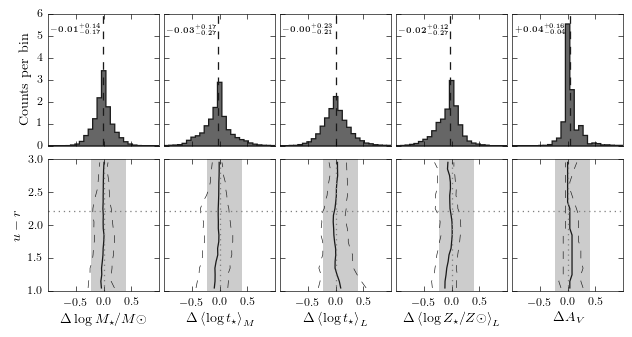

In [15]:
rc("lines", linewidth=1.0)
rc("patch", linewidth=1.0)
rc("font", family="serif", serif="Times New Roman", size=11)
rc("axes", linewidth=0.5, labelsize=11, titlesize=11)
rc("text", usetex=True)
rc("savefig", dpi=92)
rc("legend", fontsize="xx-small")
rc("xtick", labelsize="small")
rc("ytick", labelsize="small")

kw = "M_mod log_t_M_mod log_t_L_mod log_Z_L_mod Av_mod".split()
rl = [False]*5
lb = [r"$\Delta \log{M_\star/M\odot}$", r"$\Delta\left<\log{t_\star}\right>_M$", r"$\Delta\left<\log{t_\star}\right>_L$",
      r"$\Delta\left<\log{Z_\star/Z\odot}\right>_L$", r"$\Delta A_V$"]

fig, axs = subplots(2, len(kw), figsize=(7, 3.8), sharex=True, sharey="row")

lm = xlim(-1., +1.)
sp = [(-0.26,+0.13), (-0.23,+0.40), (-0.15,+0.19), (-0.24,+0.11), (-0.18,+0.19)]
axs[0, 0].set_xticks([-0.5, 0, 0.5])

for i, j in product(xrange(axs.shape[0]), xrange(axs.shape[1])):
    res = err(jpas_me[kw[j]], spec_ne[kw[j]], rl[j])
    med = median(res)
    p16, p84 = percentile(res, [16.0, 84.0])
    
    if j == 0:
        if i == 0: axs[i, j].set_ylabel("Counts per bin")
        if i == 1: axs[i, j].set_ylabel(r"$u-r$")
    
    if i == 0:
        axs[i, j].hist(res, 25, range=lm, normed=True, histtype="stepfilled", fc="0.4", ec="0.1")
        
        axs[i, j].axvline(med, ls="--", color="0.1")
        
        st_text = r"$\mathbf{%+.2f_{%+.2f}^{%+.2f}}$"%(med, p16, p84)
        axs[i, j].text(0.02, 0.85, st_text, fontsize="xx-small", color="0.1", ha="left", transform=axs[i, j].transAxes)
    else:
        x, y, e = binner(lcolor, res, "median", 20, rang=(1, 3), ebar=True)

        axs[i, j].axvspan(sp[i][0], sp[i][1], fc="0.8", ec="none")
        axs[i, j].plot(y, x, "-", color="0.1", mew=0, ms=3)
        axs[i, j].plot(y-e[0], x, "--", color="0.1", lw=0.5)
        axs[i, j].plot(y+e[1], x, "--", color="0.1", lw=0.5)
        axs[i, j].axvline(ls=":", color="0.5")
        axs[i, j].axhline(2.22, ls=":", color="0.5")
        
        axs[i, j].set_xlabel(lb[j])
        axs[i, j].set_ylim(1.0, 3.0)

tight_layout()
subplots_adjust(wspace=0.05, hspace=0.1)

savefig("JPAS-SPEC.pdf", facecolor="#C4C4C0", edgecolor="none", bbox_inches="tight")